In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from math import sqrt

# Load the data
data = pd.read_csv('https://raw.githubusercontent.com/AyushSinghChauhan/Minor_2/main/AMZN%20(3).csv', parse_dates=['Date'], index_col='Date')
data.head()


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2006-01-01,2.3735,2.4290,2.1550,2.2410,2.2410,2468206000
2006-02-01,2.1960,2.2345,1.8525,1.8720,1.8720,3310894000
2006-03-01,1.8725,1.8915,1.7570,1.8265,1.8265,2443562000
2006-04-01,1.8335,1.9420,1.7505,1.7605,1.7605,2135172000
2006-05-01,1.7595,1.8250,1.5760,1.7305,1.7305,2937920000


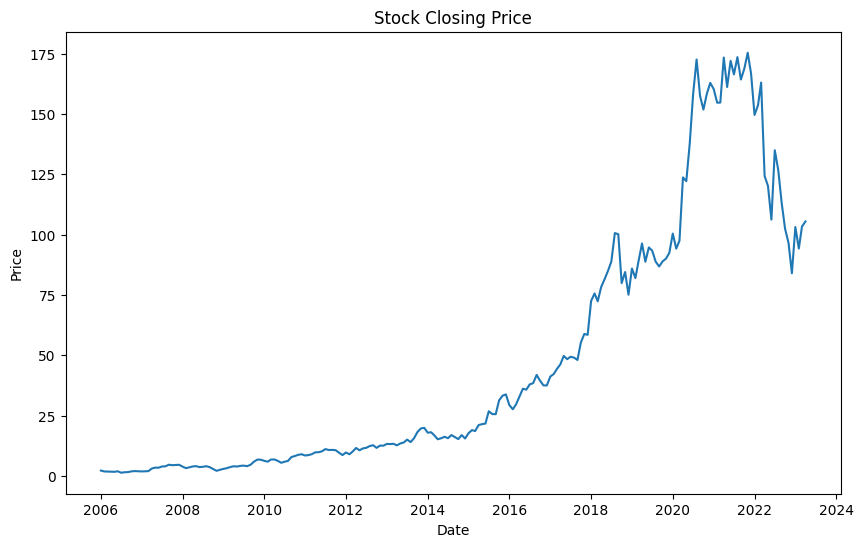

In [2]:
# Visualize the data
plt.figure(figsize=(10, 6))
plt.plot(data['Close'])
plt.title('Stock Closing Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

ADF Statistic: -0.7397273879567642
p-value: 0.8361892059325036
Critical Values:
1% -3.462980134086401
5% -2.875885461947131
10% -2.5744164898444515
Value of d:  1


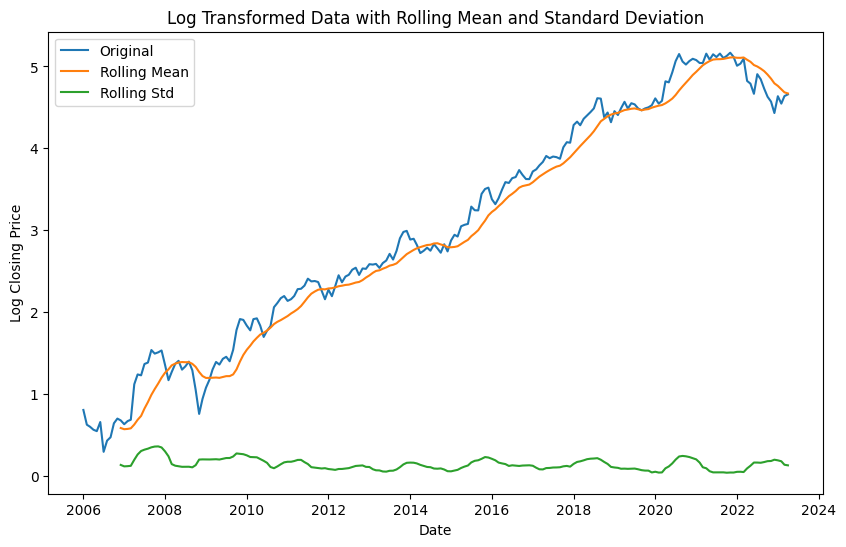

In [3]:
# ADF test for stationarity // to normalise data and to reduce the impact of extreme values
result = adfuller(data['Close'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:')
for key, value in result[4].items():
    print(key, value)
    
# Log transformation 
data['Close_log'] = np.log(data['Close'])

# Plot the rolling mean and standard deviation after log transformation
rolling_mean = data['Close_log'].rolling(window=12).mean()
rolling_std = data['Close_log'].rolling(window=12).std()

d = 0
significance_level = 0.05

while result[1] > significance_level:
    differenced_data = data['Close'].diff().dropna()  # Perform differencing
    result = adfuller(differenced_data)  # Re-run ADF test
    d += 1
print("Value of d: ",d) #The final value of "d" represents the minimum number of differencing operations required to make the time series stationary.


plt.figure(figsize=(10, 6))
plt.plot(data['Close_log'], label='Original')
plt.plot(rolling_mean, label='Rolling Mean')
plt.plot(rolling_std, label='Rolling Std')
plt.title('Log Transformed Data with Rolling Mean and Standard Deviation')
plt.xlabel('Date')
plt.ylabel('Log Closing Price')
plt.legend()
plt.show()

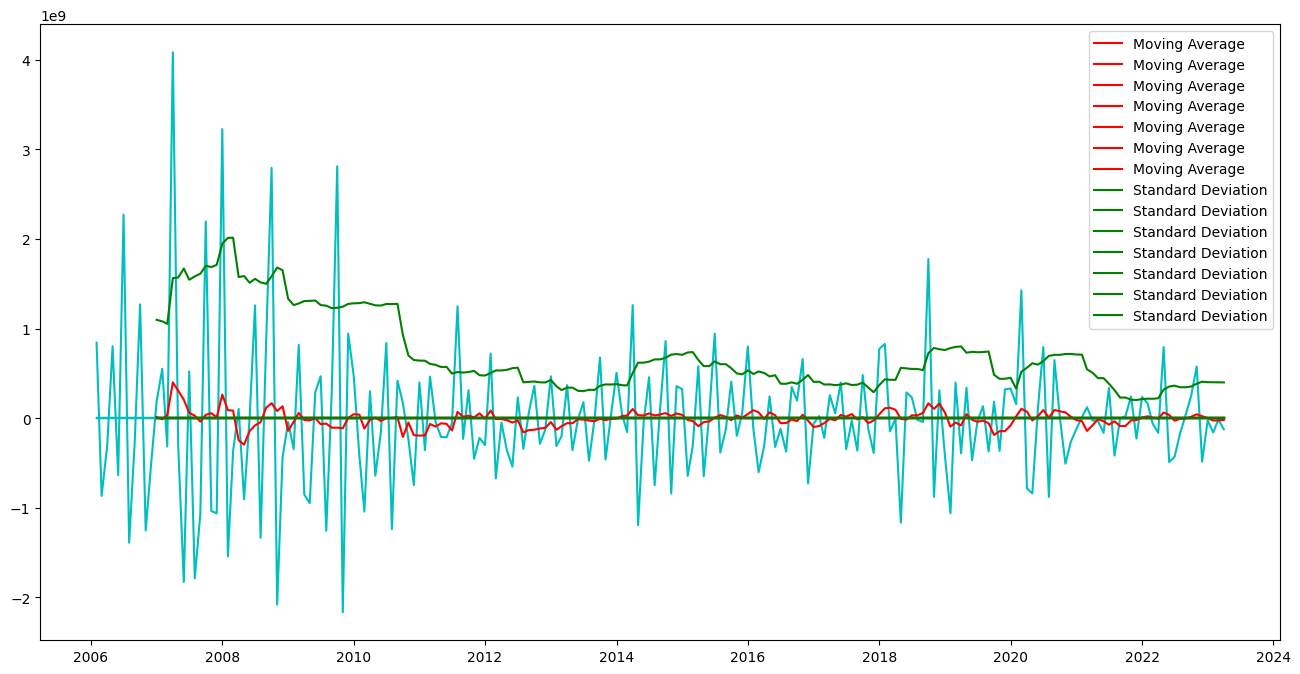

In [4]:
plt.figure(figsize=(16,8))
df_shift = data - data.shift(periods = 1)
MAvg_shift = df_shift.rolling(window=12).mean()
MStd_shift = df_shift.rolling(window=12).std()
plt.plot(df_shift, color='c')
plt.plot(MAvg_shift, color='red', label = 'Moving Average')
plt.plot(MStd_shift, color='green', label = 'Standard Deviation')
plt.legend()
plt.show()

#Dropping the null values that we get after applying differencing method
df_shift = df_shift.dropna()

In [5]:
df_shift.head()

,Open,High,Low,Close,Adj Close,Volume,Close_log
Date,,,,,,,
2006-02-01,-0.1775,-0.1945,-0.3025,-0.3690,-0.3690,842688000.0,-0.179915
2006-03-01,-0.3235,-0.3430,-0.0955,-0.0455,-0.0455,-867332000.0,-0.024606
2006-04-01,-0.0390,0.0505,-0.0065,-0.0660,-0.0660,-308390000.0,-0.036804
2006-05-01,-0.0740,-0.1170,-0.1745,-0.0300,-0.0300,802748000.0,-0.017187
2006-06-01,-0.0280,0.1170,0.0450,0.2035,0.2035,-635572000.0,0.111180


In [6]:
# ADF test for stationarity
result = adfuller(df_shift['Close'])# If the test statistic exceeds the critical value, we reject the null hypothesis;
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:') #P is probability under null hypo. and should be less than the significance level
for key, value in result[4].items():
    print(key, value)

ADF Statistic: -6.057771385280326
p-value: 1.233311200078565e-07
Critical Values:
1% -3.462980134086401
5% -2.875885461947131
10% -2.5744164898444515


In [7]:
data.sort_index(inplace=True)
data.head()

,Open,High,Low,Close,Adj Close,Volume,Close_log
Date,,,,,,,
2006-01-01,2.3735,2.4290,2.1550,2.2410,2.2410,2468206000,0.806922
2006-02-01,2.1960,2.2345,1.8525,1.8720,1.8720,3310894000,0.627007
2006-03-01,1.8725,1.8915,1.7570,1.8265,1.8265,2443562000,0.602402
2006-04-01,1.8335,1.9420,1.7505,1.7605,1.7605,2135172000,0.565598
2006-05-01,1.7595,1.8250,1.5760,1.7305,1.7305,2937920000,0.548410


In [8]:
# Reset index to convert 'Date' from index to column
data.reset_index(inplace=True)

# Verify the changes
data.head()


,Date,Open,High,Low,Close,Adj Close,Volume,Close_log
0,2006-01-01,2.3735,2.4290,2.1550,2.2410,2.2410,2468206000,0.806922
1,2006-02-01,2.1960,2.2345,1.8525,1.8720,1.8720,3310894000,0.627007
2,2006-03-01,1.8725,1.8915,1.7570,1.8265,1.8265,2443562000,0.602402
3,2006-04-01,1.8335,1.9420,1.7505,1.7605,1.7605,2135172000,0.565598
4,2006-05-01,1.7595,1.8250,1.5760,1.7305,1.7305,2937920000,0.548410


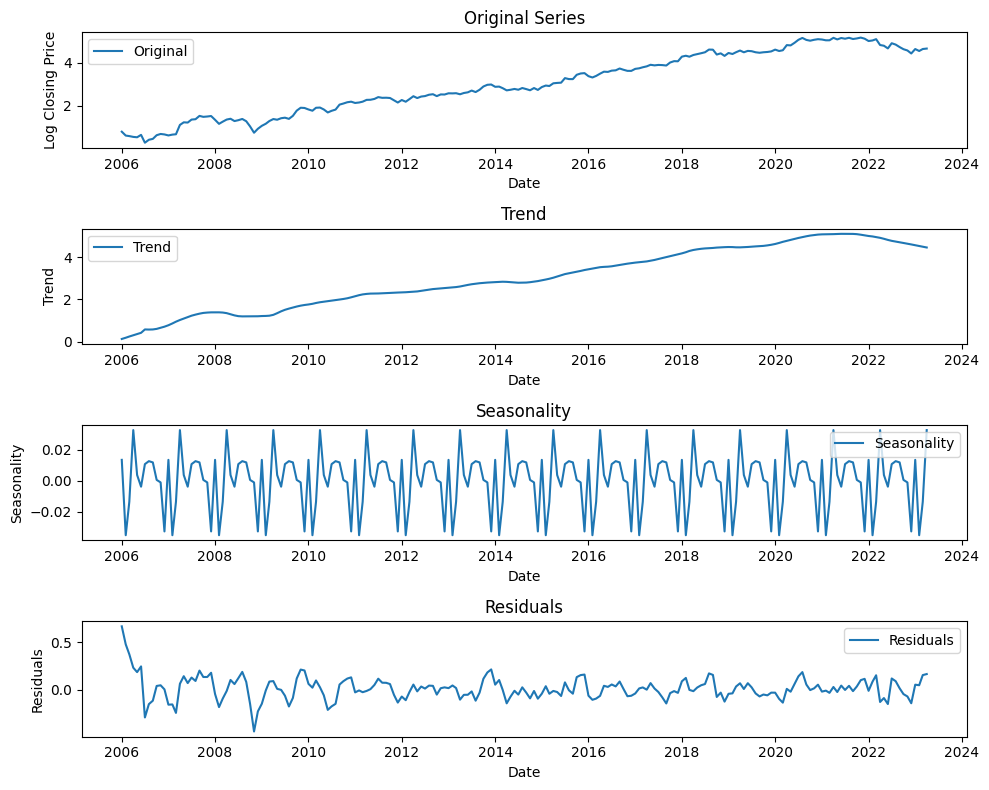

In [9]:
# Convert 'Date' column to datetime type
data['Date'] = pd.to_datetime(data['Date'])

# Set 'Date' column as the index
data.set_index('Date', inplace=True)

# Set the frequency of the DatetimeIndex
data.index.freq = pd.infer_freq(data.index)

# Decompose the time series
decomposition = seasonal_decompose(data['Close_log'], model='additive',extrapolate_trend='freq', period=12)

# Plot the decomposed components
plt.figure(figsize=(10, 8))
plt.subplot(4, 1, 1)
plt.plot(data['Close_log'], label='Original')
plt.title('Original Series')
plt.xlabel('Date')
D=1
plt.ylabel('Log Closing Price')
plt.legend()

plt.subplot(4, 1, 2)
plt.plot(decomposition.trend, label='Trend')
plt.title('Trend')
plt.xlabel('Date')
plt.ylabel('Trend')
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(decomposition.seasonal, label='Seasonality')
plt.title('Seasonality')
plt.xlabel('Date')
plt.ylabel('Seasonality')
plt.legend()

plt.subplot(4, 1, 4)
plt.plot(decomposition.resid, label='Residuals')
plt.title('Residuals')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.legend()

plt.tight_layout()
plt.show()

In [10]:
data.head()

,Open,High,Low,Close,Adj Close,Volume,Close_log
Date,,,,,,,
2006-01-01,2.3735,2.4290,2.1550,2.2410,2.2410,2468206000,0.806922
2006-02-01,2.1960,2.2345,1.8525,1.8720,1.8720,3310894000,0.627007
2006-03-01,1.8725,1.8915,1.7570,1.8265,1.8265,2443562000,0.602402
2006-04-01,1.8335,1.9420,1.7505,1.7605,1.7605,2135172000,0.565598
2006-05-01,1.7595,1.8250,1.5760,1.7305,1.7305,2937920000,0.548410


/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


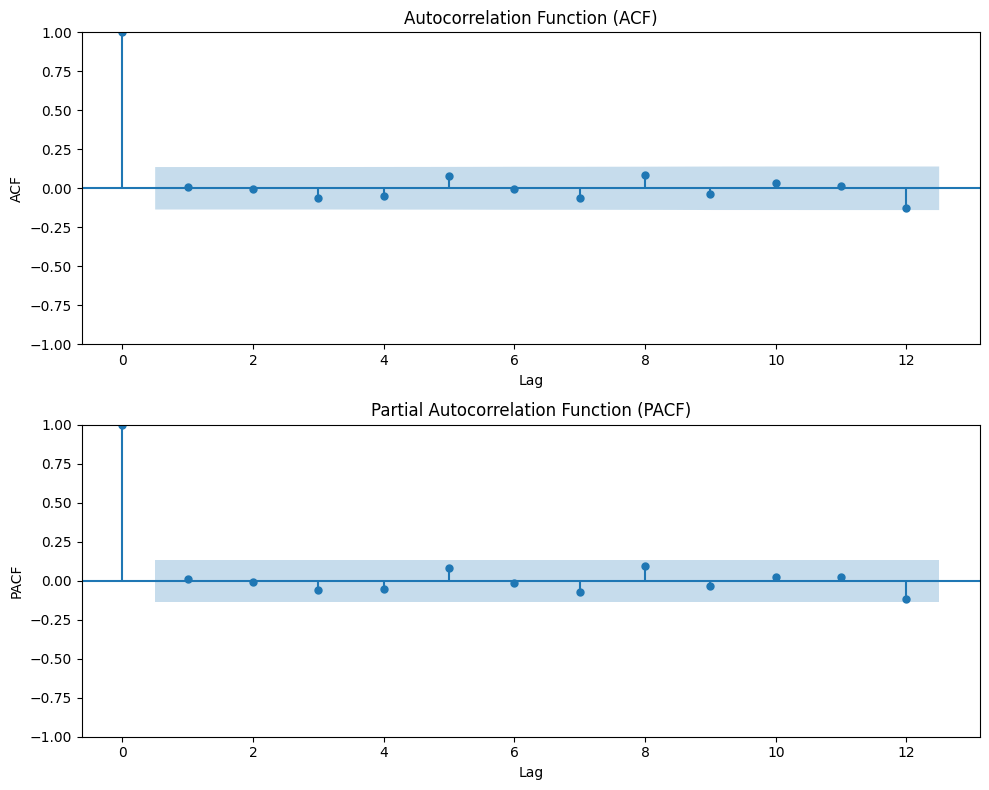

In [11]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
# the ACF plot shows the correlation of the time series with its 
#past values at different lags, while the PACF plot shows the 
#correlation between the time series and its past values after 
#removing the effects of shorter lags.

column_name = 'Close_log'  # replace with the name of the column you want to plot
column_data = df_shift[column_name].values  # select the column data and convert it to a numpy array

plot_acf(column_data, lags=12, ax=ax1)
ax1.set_title('Autocorrelation Function (ACF)')
ax1.set_xlabel('Lag')
ax1.set_ylabel('ACF')

plot_pacf(column_data, lags=12, ax=ax2)
ax2.set_title('Partial Autocorrelation Function (PACF)')
ax2.set_xlabel('Lag')
ax2.set_ylabel('PACF')

plt.tight_layout()
plt.show()


In [12]:
p=1
q=1

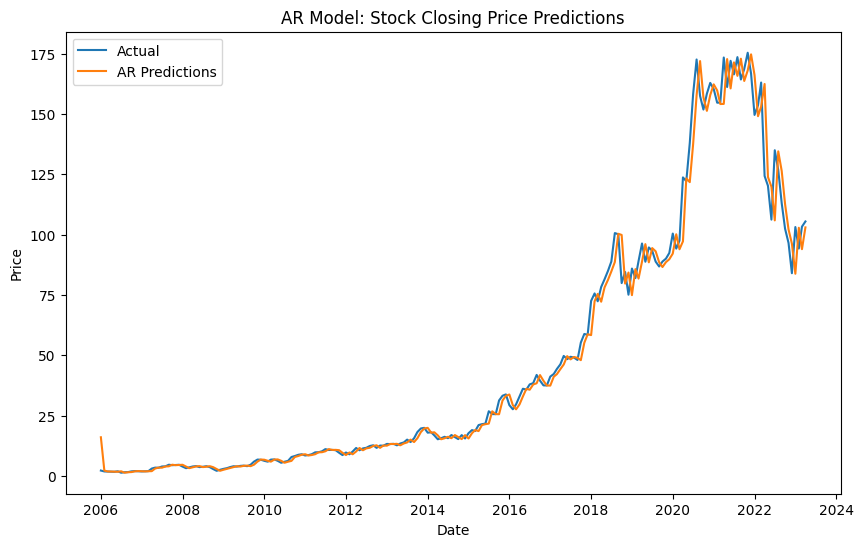

AR Model RMSE: 6.5045985215465105


In [13]:
# Fit AR model
model_ar = ARIMA(data['Close_log'].dropna(), order=(p, 0, 0))
#the order of the AR model is specified as (p, 0, 0), which means that 
#only the autoregressive component is considered in the model, 
#with p being the order of the autoregression.
results_ar = model_ar.fit()
start_idx = len(data)  # Index location of the start date
predictions_ar = results_ar.predict(start=0, end=start_idx-1)
# Generate predictions
#predictions_ar = results_ar.predict(start=start_date, end='2025-10-11')

# Inverse transform the predictions
predictions_ar = np.exp(predictions_ar)

# Plot the predicted values
plt.figure(figsize=(10, 6))
plt.plot(data['Close'], label='Actual')
plt.plot(predictions_ar, label='AR Predictions')
plt.title('AR Model: Stock Closing Price Predictions')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# Calculate RMSE
rmse_ar = np.sqrt(mean_squared_error(data['Close'], predictions_ar))
print('AR Model RMSE:', rmse_ar)


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


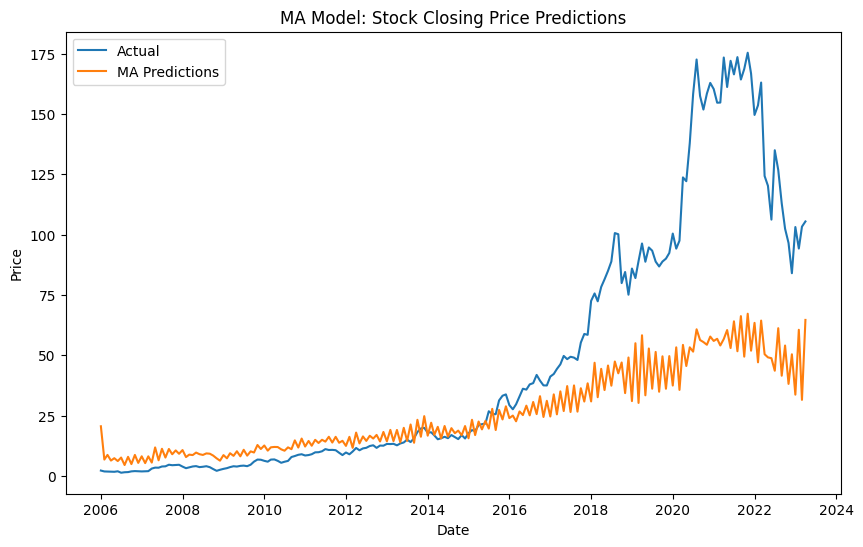

MA Model RMSE: 42.29595307948424


In [14]:
# Fit MA model
model_ma = ARIMA(data['Close_log'].dropna(), order=(0, 0, q))
results_ma = model_ma.fit()

# Generate predictions
predictions_ma = results_ma.predict(start=0, end=start_idx-1)

# Inverse transform the predictions
predictions_ma = np.exp(predictions_ma)

# Plot the predicted values
plt.figure(figsize=(10, 6))
plt.plot(data['Close'], label='Actual')
plt.plot(predictions_ma, label='MA Predictions')
plt.title('MA Model: Stock Closing Price Predictions')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# Calculate RMSE
rmse_ma = np.sqrt(mean_squared_error(data['Close'], predictions_ma))
print('MA Model RMSE:', rmse_ma)

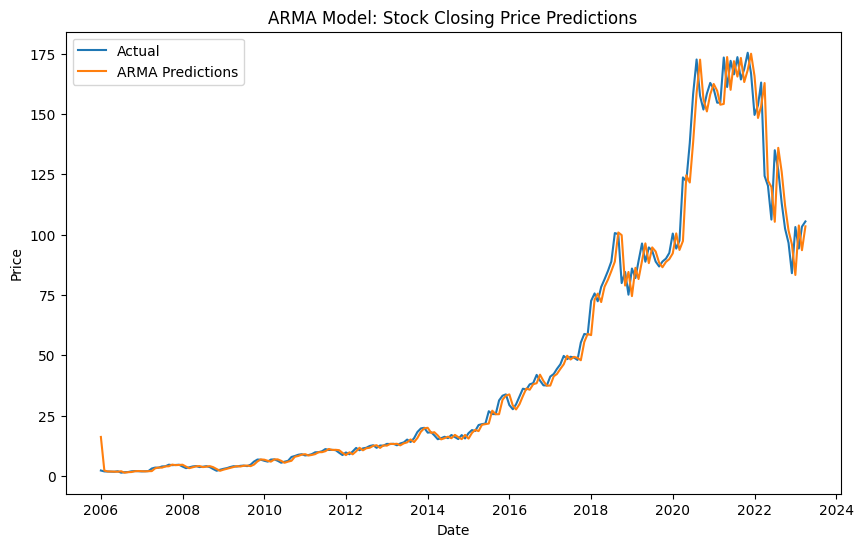

ARMA Model RMSE: 6.547559792513931


In [15]:
# Fit ARMA model
model_arma = ARIMA(data['Close_log'].dropna(), order=(p, 0, q))
results_arma = model_arma.fit()

# Generate predictions
predictions_arma = results_arma.predict(start=0, end=start_idx-1)

# Inverse transform the predictions
predictions_arma = np.exp(predictions_arma)

# Plot the predicted values
plt.figure(figsize=(10, 6))
plt.plot(data['Close'], label='Actual')
plt.plot(predictions_arma, label='ARMA Predictions')
plt.title('ARMA Model: Stock Closing Price Predictions')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# Calculate RMSE
rmse_arma = np.sqrt(mean_squared_error(data['Close'], predictions_arma))
print('ARMA Model RMSE:', rmse_arma)


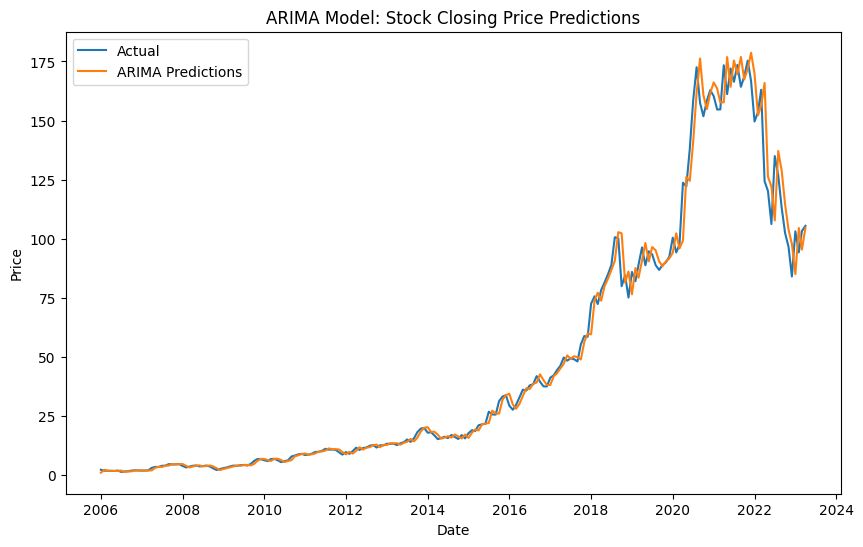

ARIMA Model RMSE: 6.550679858469556


In [16]:
# Fit ARIMA model
model_arima = ARIMA(data['Close_log'].dropna(), order=(p, d, q))
results_arima = model_arima.fit()
#p is the order of the autoregressive (AR) component, which is the number of lagged values of the time series that will be used to predict the current value.
#q is the order of the moving average (MA) component, which is the number of lagged forecast errors that will be used to predict the current value.
#d is the degree of differencing required to make the time series stationary, which involves taking the difference between consecutive observations in order to remove any trend or seasonality.

# Generate predictions
predictions_arima = results_arima.predict(start=0, end=start_idx-1)

# Inverse transform the predictions
predictions_arima = np.exp(predictions_arima)

# Plot the predicted values
plt.figure(figsize=(10, 6))
plt.plot(data['Close'], label='Actual')
plt.plot(predictions_arima, label='ARIMA Predictions')
plt.title('ARIMA Model: Stock Closing Price Predictions')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# Calculate RMSE
rmse_arima = np.sqrt(mean_squared_error(data['Close'], predictions_arima))
print('ARIMA Model RMSE:', rmse_arima)


In [17]:
import itertools
import statsmodels.api as sm

# Define the range of values for p, d, and q
p_range = range(0, 3)
d_range = range(0, 2)
q_range = range(0, 3)
P=0

# Define the range of values for P, D, Q, and m
P_range = range(0, 3)
D_range = range(0, 1)
Q_range = range(0, 3)
m = 12

# Generate all possible combinations of p, d, and q
pdq = list(itertools.product(p_range, d_range, q_range))

# Generate all possible combinations of P, D, Q, and m
PDQ = list(itertools.product(P_range, D_range, Q_range))

# Fit and evaluate SARIMA models for all possible combinations of p, d, q, P, D, Q, and m
results = []
for params in pdq:
    for seasonal_params in PDQ:
        try:
            model = sm.tsa.statespace.SARIMAX(data['Close_log'].dropna(), order=params, seasonal_order=seasonal_params)
            results.append((model.fit().bic, params, seasonal_params))
        except:
            continue

# Find the SARIMA model with the lowest BIC value
if len(results) > 0:
    best_model = min(results, key=lambda x: x[0])
    print('Best SARIMA model:', best_model[1], best_model[2])
else:
    
    D=1
    Q=2
    m=12

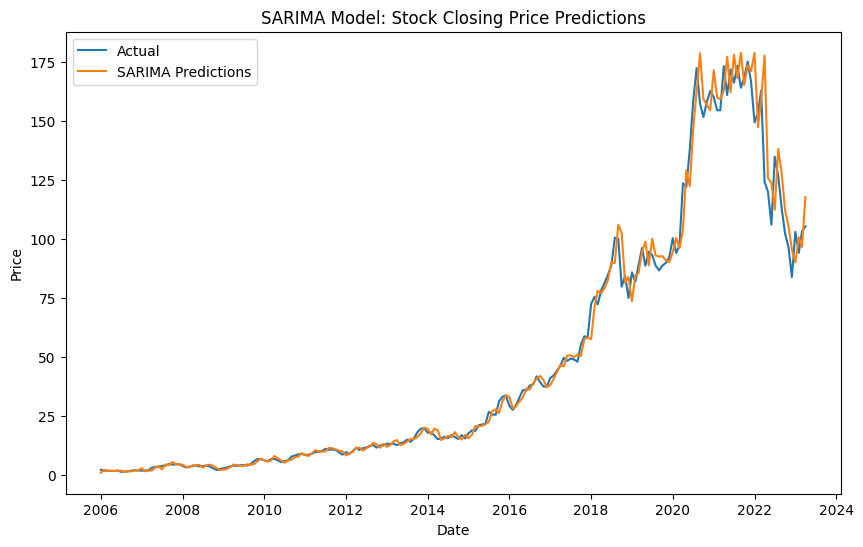

SARIMA Model RMSE: 6.9780333061717


In [18]:
# Fit SARIMA model
model_sarima = SARIMAX(data['Close_log'].dropna(), order=(p, d, q), seasonal_order=(P, D, Q, m))
results_sarima = model_sarima.fit()

# Generate predictions
predictions_sarima = results_sarima.predict(start=0, end=start_idx-1)

# Inverse transform the predictions
predictions_sarima = np.exp(predictions_sarima)

# Plot the predicted values
plt.figure(figsize=(10, 6))
plt.plot(data['Close'], label='Actual')
plt.plot(predictions_sarima, label='SARIMA Predictions')
plt.title('SARIMA Model: Stock Closing Price Predictions')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# Calculate RMSE
rmse_sarima = np.sqrt(mean_squared_error(data['Close'], predictions_sarima))
print('SARIMA Model RMSE:', rmse_sarima)


Epoch 1/50
9/9 [==============================] - 4s 31ms/step - loss: 0.0405
Epoch 2/50
9/9 [==============================] - 0s 21ms/step - loss: 0.0102
Epoch 3/50
9/9 [==============================] - 0s 17ms/step - loss: 0.0066
Epoch 4/50
9/9 [==============================] - 0s 15ms/step - loss: 0.0025
Epoch 5/50
9/9 [==============================] - 0s 17ms/step - loss: 0.0019
Epoch 6/50
9/9 [==============================] - 0s 16ms/step - loss: 0.0016
Epoch 7/50
9/9 [==============================] - 0s 26ms/step - loss: 0.0014
Epoch 8/50
9/9 [==============================] - 0s 20ms/step - loss: 0.0013
Epoch 9/50
9/9 [==============================] - 0s 15ms/step - loss: 0.0012
Epoch 10/50
9/9 [==============================] - 0s 15ms/step - loss: 0.0012
Epoch 11/50
9/9 [==============================] - 0s 14ms/step - loss: 0.0011
Epoch 12/50
9/9 [==============================] - 0s 15ms/step - loss: 0.0011
Epoch 13/50
9/9 [==============================] - 0s 20ms/st

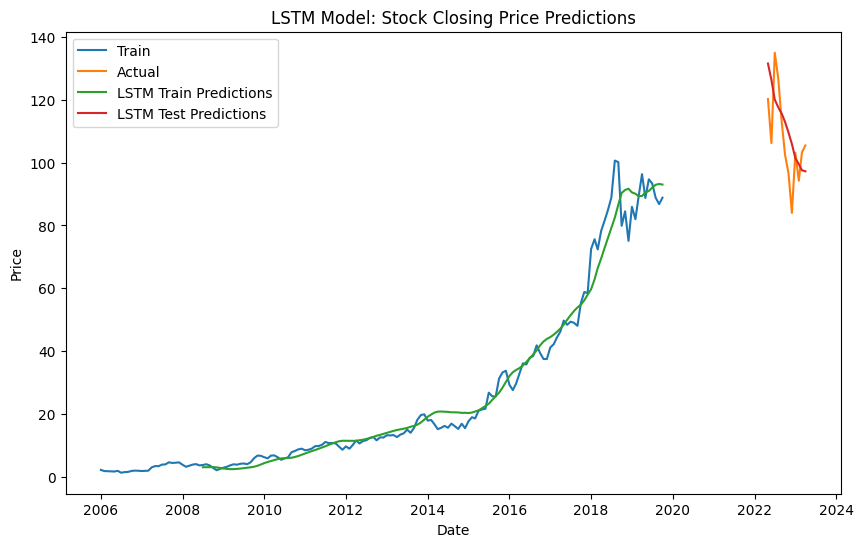

LSTM Model RMSE: 12.02431070908086


In [19]:
# Data preprocessing
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1, 1))

# Split data into train and test sets
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

# Prepare the data for LSTM
def create_sequences(data, seq_length):
    x = []
    y = []
    for i in range(len(data)-seq_length):
        x.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(x), np.array(y)

seq_length = 30
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

# Build the LSTM model
model_lstm = Sequential()
model_lstm.add(LSTM(50, input_shape=(seq_length, 1)))
model_lstm.add(Dense(1))
model_lstm.compile(loss='mean_squared_error', optimizer='adam')

# Train the LSTM model
model_lstm.fit(X_train, y_train, epochs=50, batch_size=16, verbose=1)

# Generate predictions
train_predictions_lstm = model_lstm.predict(X_train)
test_predictions_lstm = model_lstm.predict(X_test)

# Inverse transform the predictions
train_predictions_lstm = scaler.inverse_transform(train_predictions_lstm)
test_predictions_lstm = scaler.inverse_transform(test_predictions_lstm)

# Plot the predicted values
plt.figure(figsize=(10, 6))
plt.plot(data.index[:train_size], data['Close'][:train_size], label='Train')
plt.plot(data.index[train_size+seq_length:], data['Close'][train_size+seq_length:], label='Actual')
plt.plot(data.index[seq_length:train_size], train_predictions_lstm, label='LSTM Train Predictions')
plt.plot(data.index[train_size+seq_length:], test_predictions_lstm, label='LSTM Test Predictions')
plt.title('LSTM Model: Stock Closing Price Predictions')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# Calculate RMSE
rmse_lstm = np.sqrt(mean_squared_error(data['Close'][train_size+seq_length:], test_predictions_lstm))
print('LSTM Model RMSE:', rmse_lstm)


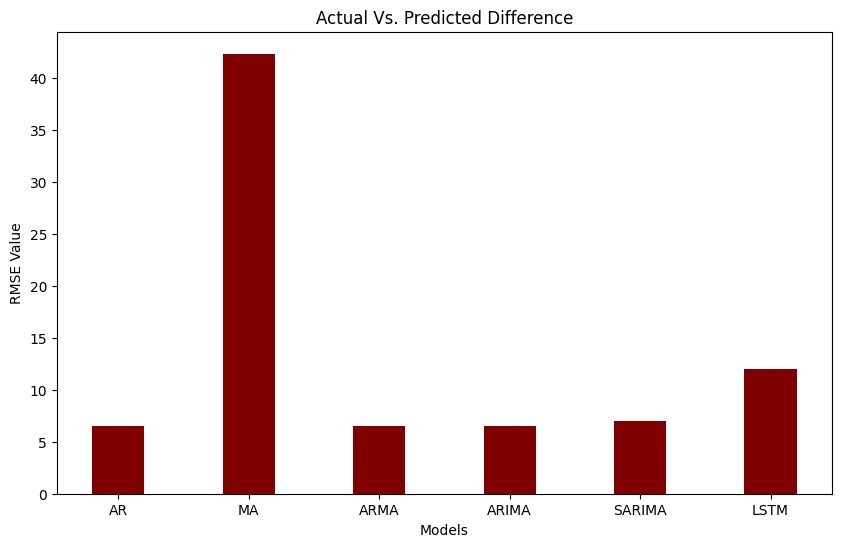

In [23]:
import numpy as np
import matplotlib.pyplot as plt

data = {'AR':rmse_ar, 'MA':rmse_ma,'ARMA':rmse_arma, 'ARIMA':rmse_arima, 'SARIMA':rmse_sarima, 'LSTM':rmse_lstm}
models = list(data.keys())
values = list(data.values())

fig = plt.figure(figsize = (10, 6))

# creating the bar plot
plt.bar(models, values, color ='maroon',width = 0.4)

plt.xlabel("Models")
plt.ylabel("RMSE Value")
plt.title("Actual Vs. Predicted Difference")
plt.show()